## Detecção CNN [`pp-yoloe small`]
1. Usar a lib super_gradients(https://github.com/Deci-AI/super-gradients)
2. Utilizar Yolox_nano,PP-YOLOE small ou SSD lite MobileNet v2
   1. Para checar hiper parâmetros disponíveis:
      1. https://github.com/Deci-AI/super-gradients/tree/master/src/super_gradients/recipes
   2. Para checar modelos disponíveis
      1. https://docs.deci.ai/super-gradients/latest/documentation/source/model_zoo.html#computer-vision-models-pretrained-checkpoints
3. Visualizar resultados

In [2]:

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

import warnings
warnings.filterwarnings("ignore")

import super_gradients
from super_gradients.training import models
from super_gradients.common.object_names import Models
import pycocotools
import torch
from torch.utils.data import Dataset
import json
from PIL import Image
from torchvision import transforms, utils
import numpy as np
import glob
import random


[2023-11-11 07:24:52] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/pablo_veinberg/sg_logs/console.log


[2023-11-11 07:24:52] WARNING - __init__.py - Failed to import pytorch_quantization
2023-11-11 07:24:54.382319: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-11 07:24:54.382347: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-11 07:24:54.382368: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-11 07:24:54.390325: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow wit

## Configs

In [1]:
NUM_CLASSES = 2
EXPERIMENT_NAME = 'transfer_learning_object_detection_pp_yoloe_small'
DECI_MODEL = Models.PP_YOLOE_S
HYPERMARAMS = 'coco2017_ppyoloe_s'

# O conjunto de dados possui apenas 2 classes = ['negative','positive']
model = models.get(DECI_MODEL, num_classes = NUM_CLASSES)

device = torch.device('cpu')
device


NameError: name 'Models' is not defined

In [5]:
class CustomDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, split, keep_difficult=False):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        :param keep_difficult: keep or discard objects that are considered difficult to detect?
        """
        self.split = split.lower()

        assert self.split in {'train', 'test'}, "Não achados os diretórios train / test"

        self.data_folder = data_folder
        self.keep_difficult = keep_difficult

        # Read data files
        self.images = glob.glob(data_folder+"images/"+self.split+"/"+"*.jpg")
        # self.images = [i.replace("\\","/") for i in self.images]
        self.images = random.sample(self.images,20)

    def __getitem__(self, i):
        # Read image and label
        image = Image.open(self.images[i].replace("\n","").replace("\\","/"), mode='r').resize((320, 320))
        image = image.convert("RGB")
        # image_tensor = torch.tensor(np.expand_dims(image,axis=-1)).permute(2, 0, 1).float()
        image_tensor = torch.tensor(np.array(image)).permute(2, 0, 1).float()
        labels = np.loadtxt(self.images[i].replace("jpg","txt").replace("images", "labels"))
        if len(labels.shape) == 1:
            labels = np.transpose(np.expand_dims(labels,axis=-1))
        return image_tensor, torch.tensor(labels,dtype=torch.float)
        

    def __len__(self):
        return len(self.images)


###  Carregar dataset

In [6]:
base_path = './../../../../Datasets/Exercicio_Deteccao/'
train_dataset = CustomDataset(base_path, split="train")
val_dataset = CustomDataset(base_path, split="test")

In [7]:
from torch.utils.data import Dataset, DataLoader
from super_gradients.training.utils.collate_fn.detection_collate_fn import DetectionCollateFN

train_dataloader = DataLoader(train_dataset, \
    batch_size=4, \
    shuffle=True, \
    num_workers=0, \
    collate_fn=DetectionCollateFN())

val_dataloader = DataLoader(val_dataset, \
    batch_size=4, \
    shuffle=False, \
    num_workers=0, \
    collate_fn=DetectionCollateFN())

In [8]:
from super_gradients.training import training_hyperparams
from prettyformatter import pprint

train_params = training_hyperparams.get(HYPERMARAMS)

print('Training parameters:')
pprint(train_params, json=True)

In [9]:
train_params['max_epochs'] = 10
# train_params['lr_warmup_epochs'] = 0
# train_params['lr_cooldown_epochs'] = 0
train_params['criterion_params']['num_classes'] = NUM_CLASSES
# train_params['average_best_models'] = False
# train_params['initial_lr'] = 0.01
# train_params['cosine_final_lr_ratio'] = 0.9
# train_params['mixed_precision'] = False
# train_params['phase_callbacks'] = []
# train_params['lr_warmup_steps'] = 10
# train_params['valid_metrics_list'] = \
#     [{"DetectionMetrics": {\
#         "post_prediction_callback": super_gradients.training.utils.ssd_utils.SSDPostPredictCallback(), \
#         "num_cls": NUM_CLASSES}}]

In [10]:
from super_gradients.training import Trainer, MultiGPUMode
CHECKPOINT_DIR = '.'

if device == 'cpu':
    super_gradients.setup_device(device='cpu')
else:
    super_gradients.setup_device(num_gpus=-1)

[2023-11-04 14:22:58] WARNING - distributed_training_utils.py - CUDA device is not available on your device... Moving to CPU.


In [11]:
%%time
from super_gradients.training.processing import ImagePermute, ComposeProcessing

image_processor = ComposeProcessing([\
    # Resize(320),
    ImagePermute(permutation=(2, 0, 1)),])

model.set_dataset_processing_params(iou=0.5, \
                                    class_names=['negative','positive'], \
                                    conf=0.5, \
                                    image_processor=image_processor)

trainer = Trainer(experiment_name = EXPERIMENT_NAME, \
                  ckpt_root_dir=CHECKPOINT_DIR)

trainer.train(model=model, \
                training_params=train_params, \
                train_loader=train_dataloader, \
                valid_loader=val_dataloader)


[2023-11-04 14:22:58] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231104_142258_060579`
[2023-11-04 14:22:58] INFO - sg_trainer.py - Checkpoints directory: ./transfer_learning_object_detection_pp_yoloe_small/RUN_20231104_142258_060579


Training parameters:
{
    "resume"    : null,
    "run_id"    : null,
    "resume_path"       : null,
    "resume_from_remote_sg_logger"      : false,
    "ckpt_name" : "ckpt_latest.pth",
    "lr_mode"   : "CosineLRScheduler",
    "lr_schedule_function"  : null,
    "lr_warmup_epochs"  : 0,
    "lr_warmup_steps"   : 1000,
    "lr_cooldown_epochs": 0,
    "warmup_initial_lr" : 1e-06,
    "step_lr_update_freq"   : null,
    "cosine_final_lr_ratio" : 0.1,
    "warmup_mode"       : "LinearBatchLRWarmup",
    "lr_updates": [],
    "pre_prediction_callback"   : null,
    "optimizer" : "AdamW",
    "optimizer_params"  : {"weight_decay": 0.0001},
    "load_opt_params"   : true,
    "zero_weight_decay_on_bias_and_bn"  : false,
    "loss"      : "PPYoloELoss",
    "criterion_params"  : {"num_classes": 80, "reg_max": 16},
    "ema"       : true,
    "ema_params": {"decay": 0.9997, "decay_type": "threshold", "beta": 15},
    "train_metrics_list": [],
    "valid_metrics_list":
        [
          

[2023-11-04 14:22:58] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9997, 'decay_type': 'threshold', 'beta': 15}
[2023-11-04 14:22:58] WARNING - callbacks.py - Number of warmup steps (1000) is greater than number of steps in epoch (5). Warmup steps will be capped to number of steps in epoch to avoid interfering with any pre-epoch LR schedulers.
[2023-11-04 14:22:58] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         OFF
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            20         (len(train_set))
    - Batch size per GPU:           4          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             4          (num_gpus * batch_size)
    - Effective Batch size:         4          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         5          (len(train_loader))
    - Gradient updates per epoch:   

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.0075
│   ├── Ppyoloeloss/loss_iou = 0.0
│   ├── Ppyoloeloss/loss_dfl = 0.0
│   └── Ppyoloeloss/loss = 0.0075
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.0103
    ├── Ppyoloeloss/loss_iou = 0.0
    ├── Ppyoloeloss/loss_dfl = 0.0
    ├── Ppyoloeloss/loss = 0.0103
    ├── Precision@0.50:0.95 = 0.0
    ├── Recall@0.50:0.95 = 0.0
    ├── Map@0.50:0.95 = 0.0
    └── F1@0.50:0.95 = 0.0



Validating epoch 1: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1e-04
│   │   ├── Epoch N-1      = 0.0075 (↘ -0.0075)
│   │   └── Best until now = 0.0075 (↘ -0.0075)
│   ├── Ppyoloeloss/loss_iou = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   └── Ppyoloeloss/loss = 1e-04
│       ├── Epoch N-1      = 0.0075 (↘ -0.0075)
│       └── Best until now = 0.0075 (↘ -0.0075)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.0026
    │   ├── Epoch N-1      = 0.0103 (↘ -0.0077)
    │   └── Best until now = 0.0103 (↘ -0.0077)
    ├── Ppyoloeloss/loss_iou = 0.0
    │   ├── Epoch N-1      = 0.0    (= 0.0)
    │   └── Best until now = 0.0    (= 0.0)
    ├── Ppyoloeloss/loss_dfl = 0.0
    │   ├── Epoch N-1      = 0.0    (= 0.0)
    │   └── Best until now = 0.0    (= 0.0)
    ├── Ppyoloeloss/loss = 0.0026
    │   ├── Epoch N-1      = 0.010

Validating epoch 2: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.0
│   │   ├── Epoch N-1      = 1e-04  (↘ -1e-04)
│   │   └── Best until now = 1e-04  (↘ -1e-04)
│   ├── Ppyoloeloss/loss_iou = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   └── Ppyoloeloss/loss = 0.0
│       ├── Epoch N-1      = 1e-04  (↘ -1e-04)
│       └── Best until now = 1e-04  (↘ -1e-04)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.0005
    │   ├── Epoch N-1      = 0.0026 (↘ -0.0021)
    │   └── Best until now = 0.0026 (↘ -0.0021)
    ├── Ppyoloeloss/loss_iou = 0.0
    │   ├── Epoch N-1      = 0.0    (= 0.0)
    │   └── Best until now = 0.0    (= 0.0)
    ├── Ppyoloeloss/loss_dfl = 0.0
    │   ├── Epoch N-1      = 0.0    (= 0.0)
    │   └── Best until now = 0.0    (= 0.0)
    ├── Ppyoloeloss/loss = 0.0005
    │   ├── Epoch N-1      = 0.0026 (↘ -0.

Validating epoch 3: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.0
│   │   ├── Epoch N-1      = 0.0    (↘ -0.0)
│   │   └── Best until now = 0.0    (↘ -0.0)
│   ├── Ppyoloeloss/loss_iou = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   └── Ppyoloeloss/loss = 0.0
│       ├── Epoch N-1      = 0.0    (↘ -0.0)
│       └── Best until now = 0.0    (↘ -0.0)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1e-04
    │   ├── Epoch N-1      = 0.0005 (↘ -0.0004)
    │   └── Best until now = 0.0005 (↘ -0.0004)
    ├── Ppyoloeloss/loss_iou = 0.0
    │   ├── Epoch N-1      = 0.0    (= 0.0)
    │   └── Best until now = 0.0    (= 0.0)
    ├── Ppyoloeloss/loss_dfl = 0.0
    │   ├── Epoch N-1      = 0.0    (= 0.0)
    │   └── Best until now = 0.0    (= 0.0)
    ├── Ppyoloeloss/loss = 1e-04
    │   ├── Epoch N-1      = 0.0005 (↘ -0.0004)
    

Validating epoch 4: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.0
│   │   ├── Epoch N-1      = 0.0    (↘ -0.0)
│   │   └── Best until now = 0.0    (↘ -0.0)
│   ├── Ppyoloeloss/loss_iou = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   └── Ppyoloeloss/loss = 0.0
│       ├── Epoch N-1      = 0.0    (↘ -0.0)
│       └── Best until now = 0.0    (↘ -0.0)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.0
    │   ├── Epoch N-1      = 1e-04  (↘ -1e-04)
    │   └── Best until now = 1e-04  (↘ -1e-04)
    ├── Ppyoloeloss/loss_iou = 0.0
    │   ├── Epoch N-1      = 0.0    (= 0.0)
    │   └── Best until now = 0.0    (= 0.0)
    ├── Ppyoloeloss/loss_dfl = 0.0
    │   ├── Epoch N-1      = 0.0    (= 0.0)
    │   └── Best until now = 0.0    (= 0.0)
    ├── Ppyoloeloss/loss = 0.0
    │   ├── Epoch N-1      = 1e-04  (↘ -1e-04)
    │   └──

Validating epoch 5: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.0
│   │   ├── Epoch N-1      = 0.0    (↘ -0.0)
│   │   └── Best until now = 0.0    (↘ -0.0)
│   ├── Ppyoloeloss/loss_iou = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   └── Ppyoloeloss/loss = 0.0
│       ├── Epoch N-1      = 0.0    (↘ -0.0)
│       └── Best until now = 0.0    (↘ -0.0)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.0
    │   ├── Epoch N-1      = 0.0    (↘ -0.0)
    │   └── Best until now = 0.0    (↘ -0.0)
    ├── Ppyoloeloss/loss_iou = 0.0
    │   ├── Epoch N-1      = 0.0    (= 0.0)
    │   └── Best until now = 0.0    (= 0.0)
    ├── Ppyoloeloss/loss_dfl = 0.0
    │   ├── Epoch N-1      = 0.0    (= 0.0)
    │   └── Best until now = 0.0    (= 0.0)
    ├── Ppyoloeloss/loss = 0.0
    │   ├── Epoch N-1      = 0.0    (↘ -0.0)
    │   └── Best 

Validating epoch 6: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.0
│   │   ├── Epoch N-1      = 0.0    (↘ -0.0)
│   │   └── Best until now = 0.0    (↘ -0.0)
│   ├── Ppyoloeloss/loss_iou = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   └── Ppyoloeloss/loss = 0.0
│       ├── Epoch N-1      = 0.0    (↘ -0.0)
│       └── Best until now = 0.0    (↘ -0.0)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.0
    │   ├── Epoch N-1      = 0.0    (↘ -0.0)
    │   └── Best until now = 0.0    (↘ -0.0)
    ├── Ppyoloeloss/loss_iou = 0.0
    │   ├── Epoch N-1      = 0.0    (= 0.0)
    │   └── Best until now = 0.0    (= 0.0)
    ├── Ppyoloeloss/loss_dfl = 0.0
    │   ├── Epoch N-1      = 0.0    (= 0.0)
    │   └── Best until now = 0.0    (= 0.0)
    ├── Ppyoloeloss/loss = 0.0
    │   ├── Epoch N-1      = 0.0    (↘ -0.0)
    │   └── Best 

Validating epoch 7: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.0
│   │   ├── Epoch N-1      = 0.0    (↘ -0.0)
│   │   └── Best until now = 0.0    (↘ -0.0)
│   ├── Ppyoloeloss/loss_iou = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   └── Ppyoloeloss/loss = 0.0
│       ├── Epoch N-1      = 0.0    (↘ -0.0)
│       └── Best until now = 0.0    (↘ -0.0)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.0
    │   ├── Epoch N-1      = 0.0    (↘ -0.0)
    │   └── Best until now = 0.0    (↘ -0.0)
    ├── Ppyoloeloss/loss_iou = 0.0
    │   ├── Epoch N-1      = 0.0    (= 0.0)
    │   └── Best until now = 0.0    (= 0.0)
    ├── Ppyoloeloss/loss_dfl = 0.0
    │   ├── Epoch N-1      = 0.0    (= 0.0)
    │   └── Best until now = 0.0    (= 0.0)
    ├── Ppyoloeloss/loss = 0.0
    │   ├── Epoch N-1      = 0.0    (↘ -0.0)
    │   └── Best 

Validating epoch 8: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.0
│   │   ├── Epoch N-1      = 0.0    (↘ -0.0)
│   │   └── Best until now = 0.0    (↘ -0.0)
│   ├── Ppyoloeloss/loss_iou = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   └── Ppyoloeloss/loss = 0.0
│       ├── Epoch N-1      = 0.0    (↘ -0.0)
│       └── Best until now = 0.0    (↘ -0.0)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.0
    │   ├── Epoch N-1      = 0.0    (↘ -0.0)
    │   └── Best until now = 0.0    (↘ -0.0)
    ├── Ppyoloeloss/loss_iou = 0.0
    │   ├── Epoch N-1      = 0.0    (= 0.0)
    │   └── Best until now = 0.0    (= 0.0)
    ├── Ppyoloeloss/loss_dfl = 0.0
    │   ├── Epoch N-1      = 0.0    (= 0.0)
    │   └── Best until now = 0.0    (= 0.0)
    ├── Ppyoloeloss/loss = 0.0
    │   ├── Epoch N-1      = 0.0    (↘ -0.0)
    │   └── Best 

Validating epoch 9: 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.0
│   │   ├── Epoch N-1      = 0.0    (↘ -0.0)
│   │   └── Best until now = 0.0    (↘ -0.0)
│   ├── Ppyoloeloss/loss_iou = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.0
│   │   ├── Epoch N-1      = 0.0    (= 0.0)
│   │   └── Best until now = 0.0    (= 0.0)
│   └── Ppyoloeloss/loss = 0.0
│       ├── Epoch N-1      = 0.0    (↘ -0.0)
│       └── Best until now = 0.0    (↘ -0.0)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.0
    │   ├── Epoch N-1      = 0.0    (↘ -0.0)
    │   └── Best until now = 0.0    (↘ -0.0)
    ├── Ppyoloeloss/loss_iou = 0.0
    │   ├── Epoch N-1      = 0.0    (= 0.0)
    │   └── Best until now = 0.0    (= 0.0)
    ├── Ppyoloeloss/loss_dfl = 0.0
    │   ├── Epoch N-1      = 0.0    (= 0.0)
    │   └── Best until now = 0.0    (= 0.0)
    ├── Ppyoloeloss/loss = 0.0
    │   ├── Epoch N-1      = 0.0    (↘ -0.0)
    │   └── Best 

[2023-11-04 14:24:30] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 10:  80%|████████  | 4/5 [00:01<00:00,  2.49it/s]

Validating epoch 10: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]
[2023-11-04 14:24:33] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
[2023-11-04 14:24:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


CPU times: user 5min 8s, sys: 7.23 s, total: 5min 15s
Wall time: 1min 35s
0


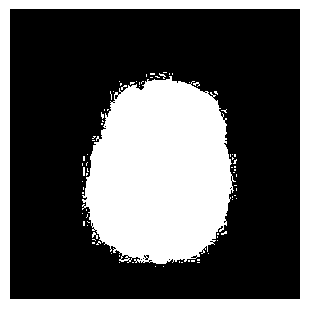

[2023-11-04 14:24:33] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2023-11-04 14:24:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


1


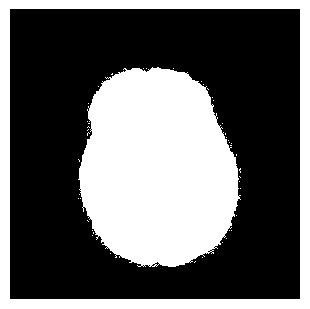

[2023-11-04 14:24:34] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2023-11-04 14:24:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


2


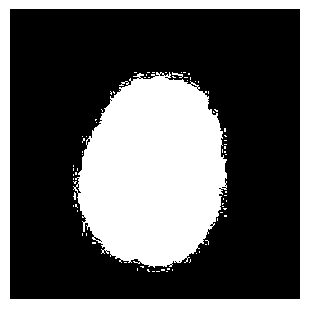

[2023-11-04 14:24:34] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2023-11-04 14:24:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


3


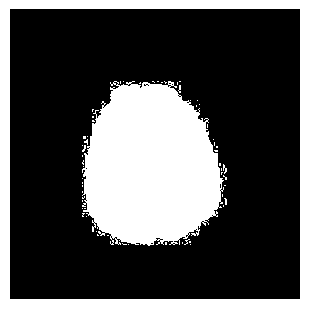

[2023-11-04 14:24:34] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2023-11-04 14:24:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


4


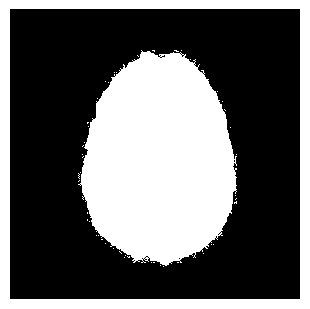

[2023-11-04 14:24:35] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2023-11-04 14:24:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


5


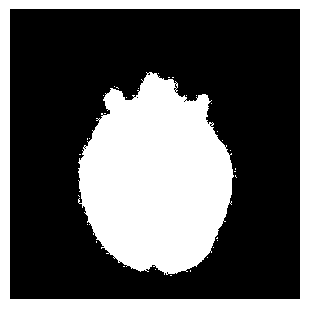

[2023-11-04 14:24:35] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2023-11-04 14:24:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


6


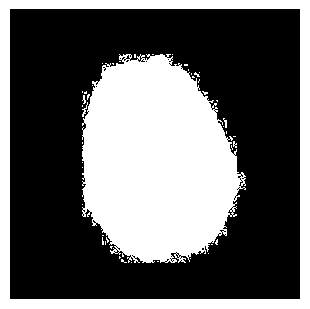

[2023-11-04 14:24:36] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2023-11-04 14:24:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


7


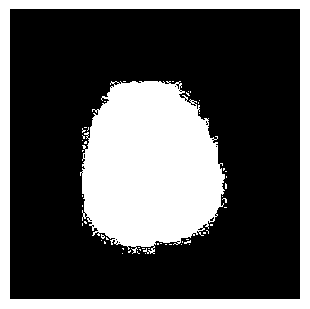

[2023-11-04 14:24:36] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2023-11-04 14:24:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


8


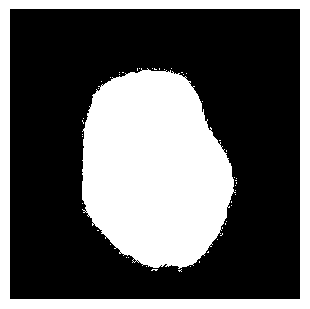

[2023-11-04 14:24:37] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2023-11-04 14:24:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


9


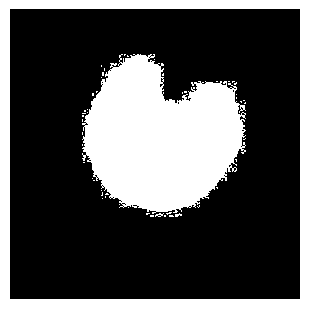

[2023-11-04 14:24:37] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2023-11-04 14:24:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


10


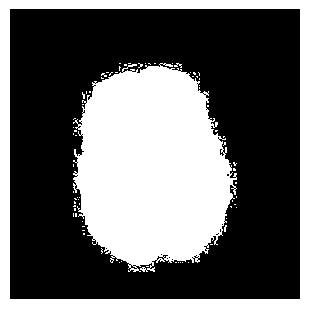

[2023-11-04 14:24:37] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2023-11-04 14:24:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


11


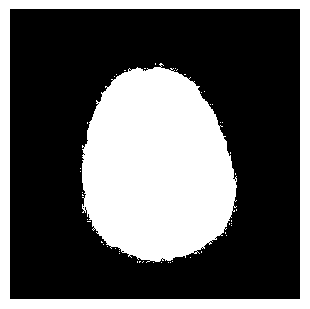

[2023-11-04 14:24:38] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2023-11-04 14:24:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


12


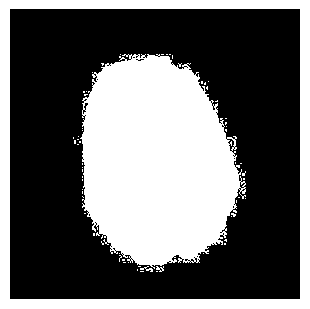

[2023-11-04 14:24:38] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2023-11-04 14:24:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


13


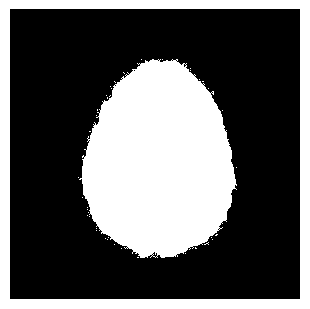

[2023-11-04 14:24:39] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2023-11-04 14:24:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


14


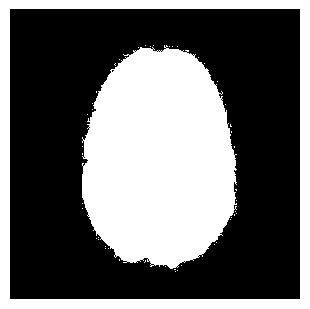

[2023-11-04 14:24:39] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2023-11-04 14:24:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


15


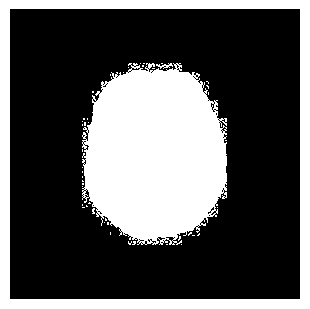

[2023-11-04 14:24:40] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2023-11-04 14:24:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


16


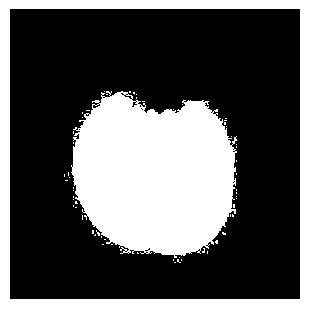

[2023-11-04 14:24:40] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2023-11-04 14:24:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


17


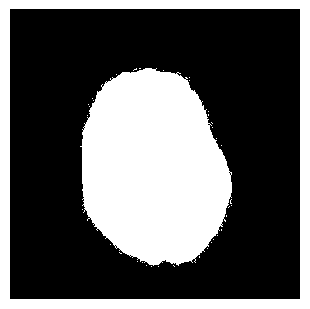

[2023-11-04 14:24:41] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[2023-11-04 14:24:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


18


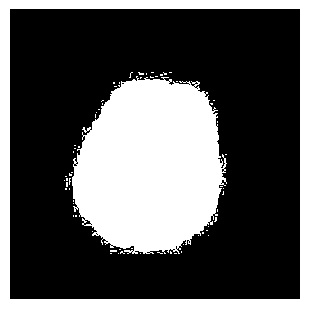

In [12]:
for pos in range(len(val_dataset)-1):
    print(pos)
    val_dataset.__getitem__(pos)[0]
    predicoes = model.predict(val_dataset.__getitem__(pos)[0])
    predicoes.show()